# Imports

In [10]:
from importlib import reload
import os
import pickle as pkl
from toolz import pipe as p

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
import dplyr_lite as d
import models_pyt as mo
import ngram_analysis as nga
import red_flag_blue_flag as rfbf
import text_utils as tu

/Users/bonihlalab/miniconda3/envs/basics/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Prepare Inputs

In [4]:
model_info_dir = 'model_info/'
get_model_info_f = lambda f: os.path.join(model_info_dir, f)

def load_model_info_pkl(name):
    with open(get_model_info_f(f'{name}.pkl'), 'rb') as f:
        ret = pkl.load(f)
    return ret

In [5]:
abstracts = pd.read_csv('content/pubmed_cr_hep_ctl_abstracts_clean.csv')

In [6]:
split_ixs_lookup =load_model_info_pkl('ixs_lookup')
vocab = load_model_info_pkl('vocab')

In [7]:
seq_len = 400

In [8]:
scan_cnn_1L = mo.ScanCnn1Logit(sequence_length=seq_len, n_terms=len(vocab.vocab) + 1).eval()

In [13]:
p(
    get_model_info_f('state_dict.pt'),
    lambda _: torch.load(_, 
                         map_location = None if torch.cuda.is_available() 
                         else torch.device('cpu')),
    scan_cnn_1L.load_state_dict
)

<All keys matched successfully>

In [14]:
logit_extract = mo.CnnLogitExtracts(scan_cnn_1L, seq_length=seq_len)

In [15]:
dataset_lookup = {
    k: tu.TextDataset(abstracts.iloc[ixs,: ], vocab, sample_len=seq_len)
    for k, ixs in split_ixs_lookup.items()
}

In [16]:
dataset_lookup

{'train': <text_utils.TextDataset at 0x7fec5cd88f40>,
 'val': <text_utils.TextDataset at 0x7fec5cd892d0>,
 'holdout': <text_utils.TextDataset at 0x7fec5cd89030>}

In [17]:
num_decode = {v: k for k, v in vocab.numericizer.items()}

In [18]:
num_decode_fn = lambda nums: [num_decode.get(n, 'UNK') for n in nums]

In [19]:
dataset_lookup['train'][10][0][:20][[4, 7]]

array([ 602, 5093])

In [20]:
' '.join(num_decode_fn(dataset_lookup['train'][10][0][:20]))

'a case of rectal gastrointestinal stromal tumor gist treated with imatinib mesylate neoadjuvant therapy to preserve the anus </s> </s>'

# Get ZF Dict

In [21]:
zf_lookup = {}
for k, ds in dataset_lookup.items():
    print(k)
    zf_lookup[k] = rfbf.get_zf_dict(scan_cnn_1L, ds, 
                               numericize=vocab.numericize, ixs_to_tokens_fn=num_decode_fn, seq_len = seq_len)

train


100%|█████████████████████████████████████████████████████████████████████████████| 4573/4573 [00:46<00:00, 99.05it/s]


val


100%|█████████████████████████████████████████████████████████████████████████████| 1144/1144 [00:11<00:00, 99.90it/s]


holdout


100%|█████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:10<00:00, 94.19it/s]


# View ZF Dict

In [22]:
zf_lookup['train'][0]

{'meta': {'fc': tensor(-0.0744),
  'w_norm': tensor(0.6120),
  'w_bias': tensor(-0.0070),
  'median_logit_+': -0.10117010772228241,
  'median_logit_-': -0.10117010772228241,
  'median_logit_delta': 0.0,
  'mean_logit_+': -0.10525077578264992,
  'mean_logit_-': -0.10829433453423243,
  'mean_logit_delta': 0.0030435587515825063,
  'auc': 0.5425686625150146},
 'sample_info': {'logit_mag': array([0.17591186, 0.1690108 , 0.16354556]),
  'net_logit': array([-0.17591186, -0.1690108 , -0.16354556]),
  'ngram': ['prothrombin', 'diagnose', 'ohss'],
  'x_norm': array([8.40863514, 7.57303238, 7.19664574]),
  'angle': array([62.54776274, 60.53745325, 59.94089036]),
  'e_dot_u': array([0.46100903, 0.49185452, 0.50089318]),
  'logit_n': array([20, 43,  1]),
  'logit_n_controls': array([ 9, 35,  1]),
  'logit_n_patients': array([12, 10,  2])}}

In [26]:
reload(rfbf)

<module 'red_flag_blue_flag' from '/Users/bonihlalab/projects/jobeid/red_flag_blue_flag/red_flag_blue_flag.py'>

In [27]:
rfbf.make_zfs_table(zf_lookup['train'], zf_lookup['holdout'], 'Hepatitis', n_rows=10, 
                     rank_method = rfbf.RankMethod.AUC, display_metric = rfbf.DisplayMetric.MEAN,
                    model1_name='Train', model2_name='Holdout')

          Train       Val
Train  1.000000  0.986664
Val    0.986664  1.000000


<AxesSubplot:title={'center':'AUC'}, xlabel='Train', ylabel='Val'>

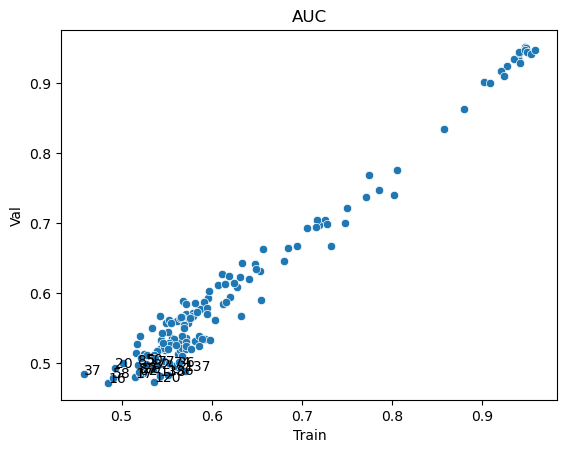

In [28]:
show_pt = lambda x, y: True
plt, cor = rfbf.view_outliers(zf_lookup['train'], zf_lookup['val'], do_show_flr_ix=lambda x, y: y < .5, meta_key='auc')
print(cor)
plt